# ONS CPI spike

In [106]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from datetime import datetime

Ideally I would like to be able to retrieve the CPI index programmatically.

## ONS API

Unfortunately, the `cpih01` api only returns data up until June 2021. 

In [116]:
url = "https://api.beta.ons.gov.uk/v1/datasets/cpih01/editions/time-series/versions/6/observations?time=*&geography=K02000001&aggregate=cpih1dim1A0"

response = requests.get(url)
response.raise_for_status()
data = response.json()

In [117]:

df_data = pd.DataFrame([{ "time": x["dimensions"]["Time"]["label"], "observation": x["observation"]} for x in data["observations"]])
df_data.head()

,time,observation
0,May-04,77.9
1,May-13,98.2
2,Sep-16,101.5
3,May-88,48.0
4,Apr-18,105.5


In [118]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   time         398 non-null    object
 1   observation  398 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB


In [119]:
df_data["observation"] = df_data["observation"].astype(float)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         398 non-null    object 
 1   observation  398 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [120]:
df_data["date"] = pd.to_datetime(df_data["time"], format="%b-%y")
df_data.head()

,time,observation,date
0,May-04,77.9,2004-05-01
1,May-13,98.2,2013-05-01
2,Sep-16,101.5,2016-09-01
3,May-88,48.0,1988-05-01
4,Apr-18,105.5,2018-04-01


In [121]:
df_data = df_data.sort_values(by="date").reset_index(drop=True)
df_data.head()

,time,observation,date
0,Jan-88,46.9,1988-01-01
1,Feb-88,47.0,1988-02-01
2,Mar-88,47.2,1988-03-01
3,Apr-88,47.8,1988-04-01
4,May-88,48.0,1988-05-01


In [122]:
df_data.tail()

,time,observation,date
393,Oct-20,109.2,2020-10-01
394,Nov-20,109.1,2020-11-01
395,Dec-20,109.4,2020-12-01
396,Jan-21,109.3,2021-01-01
397,Feb-21,109.4,2021-02-01


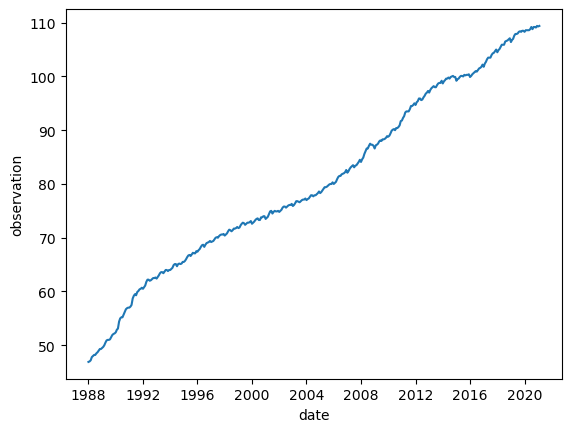

In [123]:
sns.lineplot(data=df_data, x="date", y="observation")
plt.show()

In [124]:
def get_cpi(version: str = 6):
    url = f"https://api.beta.ons.gov.uk/v1/datasets/cpih01/editions/time-series/versions/{version}/observations?time=*&geography=K02000001&aggregate=cpih1dim1A0"

    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print(data)
    if data["observations"] is None:
        return pd.DataFrame()

    df_data = pd.DataFrame([{ "time": x["dimensions"]["Time"]["label"], "observation": x["observation"]} for x in data["observations"]])
    df_data["observation"] = df_data["observation"].astype(float)
    df_data["date"] = pd.to_datetime(df_data["time"], format="%b-%y")
    df_data = df_data.sort_values(by="date").reset_index(drop=True)
    return df_data
    

In [125]:
df_cpi = get_cpi(version=12)
df_cpi.tail()

{'dimensions': {'aggregate': {'option': {'href': 'https://api.beta.ons.gov.uk/v1/code-lists/cpih1dim1aggid/codes/cpih1dim1A0', 'id': 'cpih1dim1A0'}}, 'geography': {'option': {'href': 'https://api.beta.ons.gov.uk/v1/code-lists/uk-only/codes/K02000001', 'id': 'K02000001'}}}, 'limit': 10000, 'links': {'dataset_metadata': {'href': 'https://api.beta.ons.gov.uk/v1/datasets/cpih01/editions/time-series/versions/12/metadata'}, 'self': {'href': 'https://api.beta.ons.gov.uk/v1/datasets/cpih01/editions/time-series/versions/12/observations?aggregate=cpih1dim1A0&geography=K02000001&time=*'}, 'version': {'href': 'https://api.beta.ons.gov.uk/v1/datasets/cpih01/editions/time-series/versions/12', 'id': '12'}}, 'observations': None, 'offset': 0, 'total_observations': 0, 'unit_of_measure': 'Index: 2015=100'}


""


## CPIH index

It's possible that I just wasn't able to find the data on the ONS beta API. Another option is downloading csvs published on their website. 

This data was published on the [CPIH INDEX 00: ALL ITEMS 2015=100](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l522/mm23) page.

In [126]:
from datetime import datetime

def get_num_months(from_date, to_date = datetime.now()):
    years = (to_date.year - from_date.year) * 12
    months = to_date.month - to_date.month
    return years + months

In [127]:
uri = "https://www.ons.gov.uk/generator?format=csv&uri=/economy/inflationandpriceindices/timeseries/l522/mm23"
response = requests.get(uri)
df_cpih = pd.read_csv(io.BytesIO(response.content))

num_months = get_num_months(datetime(1989,1,1))

df_cpih = df_cpih.tail(num_months).copy()
df_cpih.tail()

,Title,CPIH INDEX 00: ALL ITEMS 2015=100
632,2024 SEP,133.5
633,2024 OCT,134.3
634,2024 NOV,134.6
635,2024 DEC,135.1
636,2025 JAN,135.1


In [128]:
df_cpih.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 205 to 636
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Title                              432 non-null    object
 1   CPIH INDEX 00: ALL ITEMS 2015=100  432 non-null    object
dtypes: object(2)
memory usage: 6.9+ KB


In [129]:
df_cpih["date"] = pd.to_datetime(df_cpih["Title"], format="%Y %b")
df_cpih["index"] = df_cpih["CPIH INDEX 00: ALL ITEMS 2015=100"].astype(float)
df_cpih.head()

,Title,CPIH INDEX 00: ALL ITEMS 2015=100,date,index
205,1989 FEB,49.7,1989-02-01,49.7
206,1989 MAR,50.0,1989-03-01,50.0
207,1989 APR,50.5,1989-04-01,50.5
208,1989 MAY,50.9,1989-05-01,50.9
209,1989 JUN,51.0,1989-06-01,51.0


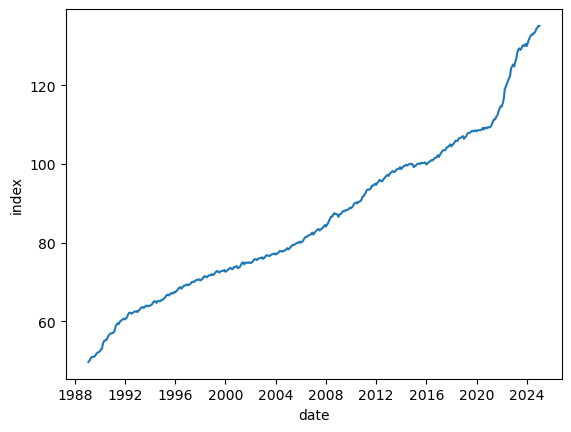

In [130]:
sns.lineplot(data=df_cpih, x="date", y="index")
plt.show()

## Conclusions

Comparing the data from the beta API with the csv download, the index doesn't match but the graphs show a consistency. For our purposes (provide some comparison) and given our time limit, using the CSV download is sufficient.